<h1>Assignment 2 of CSCI 6515</h1>

<h4> Steps: </h4>
<p><b>Step 1:</b> We fetch the first dataset from Google Big-query public dataset <b><i>https://cloud.google.com/bigqueryand</i></b> query => <q>select * from bigquery-public-data.covid19_open_data.covid19_open_data where country_name in ('Canada');</q></p>
<p><b>Step 2:</b> Select three twitter user accounts (government leaders or influencer accounts) related to public health. Example, <b><i>@CDCgovor or @GovCanHealth.</i></b></p>

<h4> Tasks: </h4>
<p> <b>1.</b> Fetch  all  selected  accounts' tweets and use them as yourinput (X) and use any word embedding library such as GloVe (Global Vectors for Word Representation).</p>
<p> <b>2.</b> Preprocess the data received from BigQuery and label the tweet messages using the Big-Query data. The label is a categorical label that has three values:
    <blockquote>-Increase the spread of COVID192.</blockquote><blockquote>-No change on the spread of COVID193.</blockquote><blockquote>-Decrease the spread of COVID19</blockquote>
    
<p> <b>3.</b> Use KMeans clustering to find the proper boundaries for labels in a target country or select boundaries based on  reasoning.</p>

<p><b>Note:</b> Today's tweet will get a label using the number of new cases in tomorrow day.</p>

<p> <b>4.a</b> Build model based on the data from November 1, 2019, to April 1,2020 and apply the data from April 1, 2020, to September 1, 2020, as your model'sdevelopment dataset.</p> 

<p> <b>4.b</b> Then use the data from September 1, 2020, to October1, 2020, to validate(test) your model. We call this model as <b>Model A</b>.</p>

<p><b>Note:</b>Now, you change your labels by the following assumption. A tweet publishedtoday will get a label using the number of new cases in 14 days after the tweetis posted.</p> 

<p> <b>5.</b> Build the second model using this assumption. Use the same developmentand validation dataset to build and test your model. Call this model <b>Model B</b>.</p>


<p> Finally, compare these two models (Model A and Model B) and suggest best model to evaluate a message before publishing by the influencer</p>


<h2>Importing Libraries:</h2>

In [95]:
import warnings
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split

In [96]:
#Ignore warnings
warnings.filterwarnings('ignore')

In [97]:
#detect current dir, optional if the csv is not in current dir
os.getcwd()

'/Users/j/Desktop/ML-BigData/A2'

<h2>Data Collection:</h2>
<p> 1. We fetch the first dataset from Google Big-query public dataset <b><i>https://cloud.google.com/bigqueryand</i></b> query => <q>select * from bigquery-public-data.covid19_open_data.covid19_open_data where country_name in ('Canada');</q></p>
<p> 2. We fetch textual data from three twitter user accounts (government leaders or influencer accounts) related to public health. Example, <b><i>@CDCgovor or @GovCanHealth.</i></b></p>

In [98]:
# Reading public covid Data
df_public_dataset = pd.read_csv('bq-results-20201014-170317-m72fmwjiyibs.csv', sep=',')

# Reading user tweets data
user1_tweets = pd.read_csv('@ScottRMcKenna_user_tweets.csv', sep=',')
user2_tweets = pd.read_csv('@OpenGovCan_user_tweets.csv', sep=',')
user3_tweets = pd.read_csv('@CDCgov_user_tweets.csv', sep=',')

<h2>Analysing the Data:</h2>
<h4>W.R.T Public Covid dataset</h4>
<p> 1. Displaying sample records of the dataset</p>
<p> 2. Checking the shape and column names of the dataset</p>
<p> 3. Describing the data obtained by calculating its standard deviation, mean, counts, etc.</p>
<p> 4. Checking for NULL values</p>

In [99]:
#displaying one sample file - weather data
df_public_dataset.head(5)

,date,location_key,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,...,datacommons_id,openstreetmap_id,latitude,longitude,location_geometry,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
0,1/1/20,CA_AB,CA,Canada,AB,Alberta,NaN,NaN,CA,CAN,...,NaN,391186.0,55.0,-115.0,POINT(-115 55),-5.088889,-10.105556,2.444444,0.000000,180.34
1,1/2/20,CA_AB,CA,Canada,AB,Alberta,NaN,NaN,CA,CAN,...,NaN,391186.0,55.0,-115.0,POINT(-115 55),-3.883333,-10.344444,0.361111,0.225778,190.50
2,1/3/20,CA_AB,CA,Canada,AB,Alberta,NaN,NaN,CA,CAN,...,NaN,391186.0,55.0,-115.0,POINT(-115 55),-8.294444,-13.661111,-0.516667,0.112889,180.34
3,1/4/20,CA_AB,CA,Canada,AB,Alberta,NaN,NaN,CA,CAN,...,NaN,391186.0,55.0,-115.0,POINT(-115 55),-6.055556,-10.161111,0.944444,0.282222,190.50
4,1/5/20,CA_AB,CA,Canada,AB,Alberta,NaN,NaN,CA,CAN,...,NaN,391186.0,55.0,-115.0,POINT(-115 55),-9.005556,-15.538889,0.138889,0.056444,170.18


In [100]:
#Shape of public COVID file
print(df_public_dataset.shape)

#displaying the column names of public Covid data
print(df_public_dataset.columns)


(30240, 45)
Index(['date', 'location_key', 'country_code', 'country_name',
       'subregion1_code', 'subregion1_name', 'subregion2_code',
       'subregion2_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3',
       'aggregation_level', 'new_confirmed', 'new_deceased', 'new_recovered',
       'new_tested', 'cumulative_confirmed', 'cumulative_deceased',
       'cumulative_recovered', 'cumulative_tested',
       'new_hospitalized_patients', 'new_intensive_care_patients',
       'new_ventilator_patients', 'cumulative_hospitalized_patients',
       'cumulative_intensive_care_patients', 'cumulative_ventilator_patients',
       'current_hospitalized_patients', 'current_intensive_care_patients',
       'current_ventilator_patients', 'mobility_transit_stations',
       'mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy',
       'mobility_parks', 'mobility_residential', 'mobility_workplaces',
       'wikidata_id', 'datacommons_id', 'openstreetmap_id', 'latitude',
       'longitude

In [101]:
#displaying the data with values and also their standard deviation,mean,count,etc - public Covid data
df_public_dataset.describe()

,subregion2_code,aggregation_level,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested,...,mobility_workplaces,datacommons_id,openstreetmap_id,latitude,longitude,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
count,26496.000000,30240.00000,27202.000000,23288.000000,2571.000000,2795.000000,27202.000000,23289.000000,2432.000000,2.808000e+03,...,5970.000000,0.0,3744.000000,3744.000000,3744.000000,3654.000000,3654.000000,3654.000000,3653.000000,1645.000000
mean,3302.913043,1.87619,13.548746,0.828796,59.901206,2926.831127,1462.936291,120.456739,5986.215049,2.353859e+05,...,-28.722781,NaN,316137.538462,54.543912,-91.965633,2.567055,-2.638177,8.379977,1.357547,288.727859
std,1357.427151,0.32937,64.722684,6.099934,489.905473,6772.050751,6110.655770,568.083738,13290.120904,5.722535e+05,...,20.209036,NaN,136791.334964,7.133740,25.154924,13.736235,13.588922,14.120195,2.806078,173.843192
min,1011.000000,1.00000,-1.000000,-2.000000,-224.000000,-20682.000000,0.000000,0.000000,0.000000,0.000000e+00,...,-87.000000,NaN,61549.000000,45.000000,-135.053230,-42.923611,-46.243056,-37.972222,0.000000,10.160000
25%,2407.750000,2.00000,0.000000,0.000000,0.000000,27.000000,4.000000,0.000000,24.000000,3.126000e+03,...,-42.000000,NaN,390558.000000,50.000000,-115.000000,-5.886111,-11.162500,-0.365278,0.025400,175.260000
50%,3541.500000,2.00000,0.000000,0.000000,0.000000,354.000000,61.000000,2.000000,284.000000,3.591850e+04,...,-32.000000,NaN,390867.000000,54.500000,-90.000000,5.589815,0.329365,11.148148,0.254000,294.640000
75%,3846.500000,2.00000,3.000000,0.000000,20.000000,1802.500000,444.000000,28.000000,2735.750000,1.424562e+05,...,-11.000000,NaN,391186.000000,55.000000,-66.000000,13.418210,8.105556,19.382407,1.333500,398.054286
max,6101.000000,2.00000,2209.000000,202.000000,23686.000000,73654.000000,86976.000000,5965.000000,72857.000000,4.250762e+06,...,36.000000,NaN,391455.000000,70.000000,-60.000000,27.366667,22.000000,36.100000,44.450000,871.220000


In [102]:
#check null fields - public Covid data
df_public_dataset.isnull().sum()

date                                      0
location_key                              0
country_code                              0
country_name                              0
subregion1_code                           0
subregion1_name                           0
subregion2_code                        3744
subregion2_name                        3744
iso_3166_1_alpha_2                        0
iso_3166_1_alpha_3                        0
aggregation_level                         0
new_confirmed                          3038
new_deceased                           6952
new_recovered                         27669
new_tested                            27445
cumulative_confirmed                   3038
cumulative_deceased                    6951
cumulative_recovered                  27808
cumulative_tested                     27432
new_hospitalized_patients             30240
new_intensive_care_patients           30240
new_ventilator_patients               30240
cumulative_hospitalized_patients

In [1]:
import platform
print(platform.python_version())

3.7.4


<h3>User tweets datasets</h3>
<h4>W.R.T User-1, User-2, User-3 </h4>
<p> 1. Displaying sample records of the dataset</p>
<p> 2. Checking the shape and column names of the dataset</p>
<p> 3. Describing the data obtained by calculating its standard deviation, mean, counts, etc.</p>
<p> 4. Checking for NULL values</p>

In [103]:
#displaying user 1 file - tweets data
user1_tweets.head(5)

,Tweet Id,Text,Name,Created At
0,1.316910e+18,@LindaSearson @HC2_SC2 @SofiyaStevens Much tha...,Scott McKenna,Fri Oct 16 01:00:41 +0000 2020
1,1.316900e+18,RT @griffstergirl : Wearing their #HatsForHope...,Scott McKenna,Fri Oct 16 00:52:28 +0000 2020
2,1.316900e+18,J'ai reçu mes 5 paquets de cartes de correspon...,Scott McKenna,Fri Oct 16 00:48:40 +0000 2020
3,1.316900e+18,Received my 5 packages of note cards in suppor...,Scott McKenna,Fri Oct 16 00:43:49 +0000 2020
4,1.316890e+18,"Been a tough week; feeling tired, stress of tr...",Scott McKenna,Fri Oct 16 00:04:50 +0000 2020


In [104]:
#displaying user 2 file - tweets data
user2_tweets.head(5)

,Tweet Id,Text,Name,Created At
0,1.317100e+18,LAST DAY TO PARTICIPATE: Are there themes you’...,Open Government CAN,Fri Oct 16 14:02:55 +0000 2020
1,1.317090e+18,Congratulations to @OpenDataSociety for launch...,Open Government CAN,Fri Oct 16 13:13:38 +0000 2020
2,1.316760e+18,"In honour of #WomensHistoryMonth, we would lik...",Open Government CAN,Thu Oct 15 15:20:13 +0000 2020
3,1.316740e+18,#DYK today is Global #Handwashing Day? Learn m...,Open Government CAN,Thu Oct 15 14:15:05 +0000 2020
4,1.316730e+18,"📢Canadians, do you want to have your say in ou...",Open Government CAN,Thu Oct 15 13:01:22 +0000 2020


In [105]:
#displaying user 3 file - tweets data
user3_tweets.head(5)

,Tweet Id,Text,Name,Created At
0,1.317140e+18,Do you do these 3 healthy habits? #WearAMask. ...,CDC,Fri Oct 16 16:09:00 +0000 2020
1,1.317120e+18,New CDC data show non-Hispanic Black persons h...,CDC,Fri Oct 16 15:24:02 +0000 2020
2,1.317110e+18,RT @CDCDiabetes : The nasal spray flu vaccine ...,CDC,Fri Oct 16 14:08:01 +0000 2020
3,1.317090e+18,RT @CDC_TB : #HealthcareWorkers: Check out the...,CDC,Fri Oct 16 13:21:01 +0000 2020
4,1.317090e+18,RT @CDCEnvironment : If your home has flooded ...,CDC,Fri Oct 16 13:08:17 +0000 2020


In [106]:
#Shape of user 1 file - tweet data
print(user1_tweets.shape)

#displaying the column names of user 1 tweet data
print(user1_tweets.columns)


#Shape of user 2 file - tweet data
print(user2_tweets.shape)

#displaying the column names of user 2 tweet data
print(user2_tweets.columns)


#Shape of user 3 file - tweet data
print(user3_tweets.shape)

#displaying the column names of user 3 tweet data
print(user3_tweets.columns)

(1213, 4)
Index(['Tweet Id', 'Text', 'Name', 'Created At'], dtype='object')
(3101, 4)
Index(['Tweet Id', 'Text', 'Name', 'Created At'], dtype='object')
(3177, 4)
Index(['Tweet Id', 'Text', 'Name', 'Created At'], dtype='object')


In [107]:
#check null fields - user 1 tweet data
user1_tweets.isnull().sum()

Tweet Id      0
Text          0
Name          0
Created At    0
dtype: int64

In [108]:
#check null fields - user 2 tweet data
user2_tweets.isnull().sum()

Tweet Id      0
Text          0
Name          0
Created At    0
dtype: int64

In [109]:
#check null fields - user 3 tweet data
user3_tweets.isnull().sum()

Tweet Id      0
Text          0
Name          0
Created At    0
dtype: int64

<h2>Data Cleaning:</h2>
<h4>W.R.T Public Covid Dataset</h4>
<p> 1. Dropped unnecessary columns from the obtained data.</p>
<p> 2. Filled the missing values for new_confirmed with zeros.</p>
<p> 3. Converted the Date column in the dataset into datetime format.</p>
<p> 4. Grouped and indexed the data based on dates.</p>
<p> 5. Selected the data between Nov 1st 2019 to Oct 1st 2020.</p>

In [110]:
#preprocessing function
#removing unnecessary features
#fill missing values
#change data column format to datetime
#group the data based on date column by summing their values in new_confirmed
def preprocessing(df):
    df = df.drop(['location_key', 'country_code', 'country_name', 'subregion1_code', 'subregion1_name', 'subregion2_code', 'subregion2_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level', 'new_deceased', 'new_recovered','new_tested', 'cumulative_confirmed', 'cumulative_deceased','cumulative_recovered', 'cumulative_tested','new_hospitalized_patients', 'new_intensive_care_patients','new_ventilator_patients', 'cumulative_hospitalized_patients','cumulative_intensive_care_patients', 'cumulative_ventilator_patients','current_hospitalized_patients', 'current_intensive_care_patients','current_ventilator_patients', 'mobility_transit_stations','mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy','mobility_parks', 'mobility_residential', 'mobility_workplaces','wikidata_id', 'datacommons_id', 'openstreetmap_id', 'latitude','longitude', 'location_geometry', 'average_temperature_celsius','minimum_temperature_celsius', 'maximum_temperature_celsius','rainfall_mm', 'snowfall_mm'], axis=1)
    df = df.fillna(0)
    df['date'] = pd.to_datetime(df['date'])
    df = df.groupby(df['date'], as_index=False).sum()
    df = df[~(df['date'] <= '2019-10-31')]
    df = df[~(df['date'] > '2020-10-01')]
    return df

In [111]:
#calling the resuable function on public COVID dataset
df_public_dataset = preprocessing(df_public_dataset)
df_public_dataset

,date,new_confirmed
0,2020-01-01,0.0
1,2020-01-02,0.0
2,2020-01-03,0.0
3,2020-01-04,0.0
4,2020-01-05,0.0
...,...,...
270,2020-09-27,2865.0
271,2020-09-28,4418.0
272,2020-09-29,3329.0
273,2020-09-30,3613.0


<h3> Creating Covid public dataset for November and December 2019 </h3>

In [112]:
#creating a new dataset for confirmed cases between Nov 1 - Dec 31st 2019
#grouped and summed by date
#resetted the index of the newly created dataset
data = {'date':list(pd.date_range('11-01-2019','12-31-2019', freq ='D')), 'new_confirmed': list(0 for i in range(0,61))}
df_nov_dec = pd.DataFrame(data, columns = ['date','new_confirmed'])
df_nov_dec = df_nov_dec.groupby(df_nov_dec['date']).sum()
df_nov_dec = df_nov_dec.reset_index()
df_nov_dec

,date,new_confirmed
0,2019-11-01,0
1,2019-11-02,0
2,2019-11-03,0
3,2019-11-04,0
4,2019-11-05,0
...,...,...
56,2019-12-27,0
57,2019-12-28,0
58,2019-12-29,0
59,2019-12-30,0


<h3> Concatenating of two COVID datasets </h3>
<p> 1. The public COVID dataset from 1st Jan 2020 - 14 Oct 2020. </p>
<p> 2. Created COVID dataset from 1st Nov - 31st Dec 2019. </p> 

In [113]:
#concatenated public COVID dataset and the newly created dataset to form the final COVID dataset
#sorted the dataset by date
#resetted the index of the final COVID dataset and displaying the sample values
df_public_dataset_final = pd.concat([df_public_dataset,df_nov_dec], ignore_index=True)
df_public_dataset_final = df_public_dataset_final.sort_values(by=['date'])
df_public_dataset_final = df_public_dataset_final.reset_index(drop=True)
df_public_dataset_final

,date,new_confirmed
0,2019-11-01,0.0
1,2019-11-02,0.0
2,2019-11-03,0.0
3,2019-11-04,0.0
4,2019-11-05,0.0
...,...,...
331,2020-09-27,2865.0
332,2020-09-28,4418.0
333,2020-09-29,3329.0
334,2020-09-30,3613.0


<h3>Created a function to label the class attribute based on <i>new_confirmed</i> cases (Tomorrow): </h3>

In [114]:
#created a function to create label for the increase/decrease/no change in covid cases
Label = [] 
for i in range(len(df_public_dataset_final)):
    if i != len(df_public_dataset_final) - 1:
        if df_public_dataset_final.iloc[i, 1] < df_public_dataset_final.iloc[i+1, 1]:
            Label.append("Increase the spread of COVID19")
            
        elif df_public_dataset_final.iloc[i, 1] > df_public_dataset_final.iloc[i+1, 1]: 
            Label.append("Decrease the spread of COVID19")
        else: 
            Label.append("No change on the spread of COVID19")
    else:
        Label.append("No change on the spread of COVID19")

df_public_dataset_final["Label"] = 0
a = 0
for j in Label:
    df_public_dataset_final["Label"][a] = j
    a = a + 1

#displaying the final dataset after labelling
df_public_dataset_final

,date,new_confirmed,Label
0,2019-11-01,0.0,No change on the spread of COVID19
1,2019-11-02,0.0,No change on the spread of COVID19
2,2019-11-03,0.0,No change on the spread of COVID19
3,2019-11-04,0.0,No change on the spread of COVID19
4,2019-11-05,0.0,No change on the spread of COVID19
...,...,...,...
331,2020-09-27,2865.0,Increase the spread of COVID19
332,2020-09-28,4418.0,Decrease the spread of COVID19
333,2020-09-29,3329.0,Increase the spread of COVID19
334,2020-09-30,3613.0,Decrease the spread of COVID19


<h4> Labelling the target class.</h4>

In [115]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_public_dataset_final.iloc[:,-1] = le.fit_transform(df_public_dataset_final.iloc[:,-1])
df_public_dataset_final

,date,new_confirmed,Label
0,2019-11-01,0.0,2
1,2019-11-02,0.0,2
2,2019-11-03,0.0,2
3,2019-11-04,0.0,2
4,2019-11-05,0.0,2
...,...,...,...
331,2020-09-27,2865.0,1
332,2020-09-28,4418.0,0
333,2020-09-29,3329.0,1
334,2020-09-30,3613.0,0


<h3> Concatenating of three user tweet datasets </h3> 

In [116]:
#concatenation of three ifferent user tweets
df_tweets_final = pd.concat([user1_tweets,user2_tweets,user3_tweets], ignore_index=True)

<h4>W.R.T Public tweets Dataset</h4>
<p> 1. Renamed the date column and dropped unnecessary columns from the obtained data.</p>
<p> 2. Converted the date column into datetime format and renamed it.</p>
<p> 3. Sorted and filtered the unnecessary data by removing them with dates</p>
<p> 4. Resetted the index of the tweet dataset.</p>

In [117]:
#preprocessing function
#rename the date column
#removing unnecessary features
#converted the date column into datetime format and renamed it
#filtered the unnecessary data by removing them with dates
#resetted the index and sorted the values with dates.

def preprocessing2(df):
    df = df.rename(columns={"Created At": "date"})
    df = df.drop(['Tweet Id', 'Name'], axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.date
    df['date'] = df['date'].astype('datetime64[ns]')
    df = df.sort_values(by=['date'])
    df = df[~(df['date'] <= '2019-10-31')]
    df = df[~(df['date'] > '2020-10-01')]
    df = df.reset_index(drop=True)
    return df

In [118]:
#calling the preprocessing function
df_tweets_final = preprocessing2(df_tweets_final)
df_tweets_final

,Text,date
0,YES!!! I can't wait for the Pixelwatch or Goog...,2019-11-01
1,RT @ACSP_Canada : Saviez-vous que le #vapotage...,2019-11-01
2,Nothing like a power outage to create an oppor...,2019-11-01
3,RT @CPHO_Canada : Did you know #vaping nicotin...,2019-11-01
4,Interested in a specific topic? We probably ha...,2019-11-02
...,...,...
4190,School administrators: Use CDC’s new monitorin...,2020-10-01
4191,A new @CDCMMWR report offers a snapshot of the...,2020-10-01
4192,RT @ivana_macmillan : The (HC)2 online virtual...,2020-10-01
4193,RT @Criccicav : Lockdown measures were extreme...,2020-10-01


<h3>Contractions (tweets dataset):</h3>
<p> 1. Replacing the contracted words with complete words</p>

In [119]:
#converting to lower case
#changing the contracted words to complete words by using replace method
def contraction(text):
    text['Text'] = text['Text'].str.lower()
    text['Text'] = text['Text'].replace(to_replace=r'ain\'t', value='am not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'aren\'t', value='are not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'can\'t', value='can not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'can\'t\'ve', value='can not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'\'cause', value='because', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'could\'ve', value='could have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'couldn\'t', value='could not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'couldn\'t\'ve', value='could not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'didn\'t', value='did not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'doesn\'t', value='does not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'don\'t', value='do not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'hadn\'t', value='had not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'hadn\'t\'ve', value='had not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'hasn\'t', value='has not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'haven\'t', value='have not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'he\'d', value='he had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'he\'d\'ve', value='he would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'he\'ll', value='he will', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'he\'ll\'ve', value='he will have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'he\'s', value='he has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'how\'d', value='how did', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'how\'d\'y', value='how do you', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'how\'ll', value='how will', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'how\'s', value='how has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'i\'d', value='I had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'i\'d\'ve', value='I would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'i\'ll', value='I shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'i\'ll\'ve', value='I shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'i\'m', value='I am', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'im ', value='I am', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'i\'ve', value='I have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'isn\'t', value='is not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'it\'d', value='it had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'it\'d\'ve', value='it would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'it\'ll', value='it shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'it\'ll\'ve', value='it shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'it\'s', value='it has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'let\'s', value='let us', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'ma\'am', value='madam', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'mayn\'t', value='may not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'might\'ve', value='might have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'mightn\'t', value='might not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'mightn\'t\'ve', value='might not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'must\'ve', value='must have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'mustn\'t', value='must not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'mustn\'t\'ve', value='must not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'needn\'t', value='need not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'needn\'t\'ve', value='need not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'o\'clock', value='of the clock', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'oughtn\'t', value='ought not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'oughtn\'t\'ve', value='ought not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'shan\'t', value='shall not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'sha\'n\'t', value='shall not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'shan\'t\'ve', value='shall not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'she\'d', value='she had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'she\'d\'ve', value='she would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'she\'ll', value='she shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'she\'ll\'ve', value='she shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'she\'s', value='she has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'should\'ve', value='should have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'shouldn\'t', value='should not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'shouldn\'t\'ve', value='should not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'so\'ve', value='so have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'so\'s', value='so as', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'that\'d', value='that would', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'that\'d\'ve', value='that would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'that\'s', value='that has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'there\'d', value='there had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'there\'d\'ve', value='there would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'there\'s', value='there has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'they\'d', value='they had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'they\'d\'ve', value='they would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'they\'ll', value='they shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'they\'ll\'ve', value='they shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'they\'re', value='they are', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'they\'ve', value='they have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'to\'ve', value='to have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'wasn\'t', value='was not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'we\'d', value='we had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'we\'d\'ve', value='we would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'we\'ll', value='we will', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'we\'ll\'ve', value='we will have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'we\'re', value='we are', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'we\'ve', value='we have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'weren\'t', value='were not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'what\'ll', value='what shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'what\'ll\'ve', value='what shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'what\'re', value='what are', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'what\'s', value='what has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'what\'ve', value='what have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'when\'s', value='when has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'when\'ve', value='when have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'where\'d', value='where did', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'where\'s', value='where has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'where\'ve', value='where have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'who\'ll', value='who shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'who\'ll\'ve', value='who shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'who\'s', value='who has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'who\'ve', value='who have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'why\'s', value='why has', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'why\'ve', value='why have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'will\'ve', value='will have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'won\'t', value='will not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'won\'t\'ve', value='will not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'would\'ve', value='would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'wouldn\'t', value='would not', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'wouldn\'t\'ve', value='would not have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'y\'all', value='you all', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'y\'all\'d', value='you all would', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'y\'all\'d\'ve', value='you all would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'y\'all\'re', value='you all are', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'y\'all\'ve', value='you all have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'you\'d', value='you had', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'you\'d\'ve', value='you would have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'you\'ll', value='you shall', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'you\'ll\'ve', value='you shall have', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'you\'re', value='you are', regex=True)
    text['Text'] = text['Text'].replace(to_replace=r'you\'ve', value='you have', regex=True)
    return(text)

In [120]:
#calling the contractions function and diplaying the sample values from the dataset after performing contractions removal
df_tweets_final = contraction(df_tweets_final)
df_tweets_final

,Text,date
0,yes!!! i can not wait for the pixelwatch or go...,2019-11-01
1,rt @acsp_canada : saviez-vous que le #vapotage...,2019-11-01
2,nothing like a power outage to create an oppor...,2019-11-01
3,rt @cpho_canada : did you know #vaping nicotin...,2019-11-01
4,interested in a specific topic? we probably ha...,2019-11-02
...,...,...
4190,school administrators: use cdc’s new monitorin...,2020-10-01
4191,a new @cdcmmwr report offers a snapshot of the...,2020-10-01
4192,rt @ivana_macmillan : the (hc)2 online virtual...,2020-10-01
4193,rt @criccicav : lockdown measures were extreme...,2020-10-01


In [121]:
#cleaning function
#removing the mentions
#removing the hashtags
#removing the junk characters and irrelavant alphabets
#removing the URLs
#selecting only alphabets for the final dataset and removing the rest

def cleaning(data):
    data['Text'] = data['Text'].str.replace(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([_A-Za-z]+[A-Za-z0-9_]+)','')  #mentions
    data['Text'] = data['Text'].str.replace(r'#(\w+)','')    #hashtags
    data['Text'] = data['Text'].str.replace(r'^(rt[\s]+\:)','')   #remove 'RT' in the begining
    data['Text'] = data['Text'].str.replace(r'https?:\/\/.*[\r\n]*', '') #URLs
    data['Text'] = data['Text'].str.replace(r'([^A-Za-z]+)', ' ')  #only alphabets selected
    data['Text'] = data['Text'].str.replace(r'^[\s]+$', 'NaN')
    data = data[~data.Text.str.contains("NaN")]
    data = data.reset_index(drop=True)
    return(data)

In [122]:
#calling the cleaning function and diplaying the sample values from the dataset after performing data cleaning
df_tweets_final = cleaning(df_tweets_final)
df_tweets_final

,Text,date
0,yes i can not wait for the pixelwatch or googl...,2019-11-01
1,saviez vous que le de nicotine peut mener une...,2019-11-01
2,nothing like a power outage to create an oppor...,2019-11-01
3,did you know nicotine can lead to addiction y...,2019-11-01
4,interested in a specific topic we probably hav...,2019-11-02
...,...,...
4166,getting a is more important than ever join s d...,2020-10-01
4167,school administrators use cdc s new monitoring...,2020-10-01
4168,a new report offers a snapshot of the partners...,2020-10-01
4169,the hc online virtual escape room tournament ...,2020-10-01


<h3> Data Visualization (Before stopwords removal and lemmatization):</h3>

In [123]:
#Calculating the count of each word occurences
words_list_before = df_tweets_final['Text'].str.split(expand=True).unstack().value_counts()

In [124]:
#bar graph to represent the most frequent words
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
data = [go.Bar(
            x = words_list_before.index.values[0:50],
            y = words_list_before.values[0:50],
            marker= dict(colorscale='Viridis',
                         color = words_list_before.values[0:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Before preprocessing frequent Occuring words'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

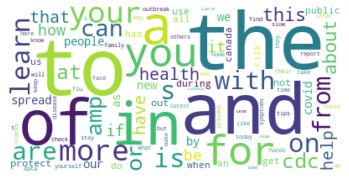

In [125]:
#Word Cloud to represent the most frequent words
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', max_words = 100).generate_from_frequencies(words_list_before)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3> Preprocessing (lemmatization and stopwords removal): </h3>

<h3> Stopwords Removal: </h3>

In [127]:
#created a list of stopwords to be removed from the textual data
stopwords_removal = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those','am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "u", "ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than"]

<h3> Lemmatization: </h3>
<p> 1. Transforming the words in the Textual data into its root form </p>

In [128]:
def Lemmatizaton(df):
    word_Lemmatized = WordNetLemmatizer()
    for index, text in enumerate(df['Text']):
        temp = []
        for word in str(text).split():
            word = word.strip()
            if word not in stopwords_removal and word.isalpha():
                lemmatize_word = word_Lemmatized.lemmatize(word)
                temp.append(lemmatize_word)
        df.loc[index,'Text'] = str(" ".join(temp))
    return df

In [129]:
#calling lemmatization function and displaying the sample data
df_tweets_final_processed = Lemmatizaton(df_tweets_final)
df_tweets_final_processed

,Text,date
0,yes wait pixelwatch googlewatch whatever call ...,2019-11-01
1,saviez vous que le de nicotine peut mener une ...,2019-11-01
2,nothing like power outage create opportunity j...,2019-11-01
3,know nicotine lead addiction young people part...,2019-11-01
4,interested specific topic probably dataset art...,2019-11-02
...,...,...
4166,getting important ever join dr dan jernigan ro...,2020-10-01
4167,school administrator use cdc new monitoring ev...,2020-10-01
4168,new report offer snapshot partnership cdc stat...,2020-10-01
4169,hc online virtual escape room tournament begun...,2020-10-01


In [130]:
#Calculating the count of each word occurences
words_list_after = df_tweets_final_processed['Text'].str.split(expand=True).unstack().value_counts()

In [131]:
#bar graph to represent the most frequent words
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
data = [go.Bar(
            x = words_list_after.index.values[0:50],
            y = words_list_after.values[0:50],
            marker= dict(colorscale='Viridis',
                         color = words_list_after.values[0:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='After preprocessing frequent Occuring words'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

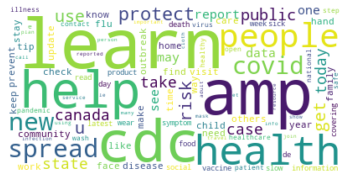

In [132]:
#Word Cloud to represent the most frequent words
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', max_words = 100).generate_from_frequencies(words_list_after)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4>Concatenation of tweets and COVID public Dataset</h4>
<p> 1. Merged the datasets based on date.</p>

In [133]:
final_combined = pd.merge(df_tweets_final, df_public_dataset_final, on='date', how='left')
final_combined = final_combined[['date', 'Text', 'Label']]
final_combined

,date,Text,Label
0,2019-11-01,yes wait pixelwatch googlewatch whatever call ...,2
1,2019-11-01,saviez vous que le de nicotine peut mener une ...,2
2,2019-11-01,nothing like power outage create opportunity j...,2
3,2019-11-01,know nicotine lead addiction young people part...,2
4,2019-11-02,interested specific topic probably dataset art...,2
...,...,...,...
4166,2020-10-01,getting important ever join dr dan jernigan ro...,2
4167,2020-10-01,school administrator use cdc new monitoring ev...,2
4168,2020-10-01,new report offer snapshot partnership cdc stat...,2
4169,2020-10-01,hc online virtual escape room tournament begun...,2


<h3> Splitting the main dataset into train, development and test sets </h3>

In [134]:
final_combined_train =  final_combined
final_combined_train = final_combined_train[~(final_combined_train['date'] < '2019-11-01')]
final_combined_train = final_combined_train[~(final_combined_train['date'] > '2020-04-01')]

final_combined_dev = final_combined
final_combined_dev = final_combined_dev[~(final_combined_dev['date'] < '2020-04-01')]
final_combined_dev = final_combined_dev[~(final_combined_dev['date'] > '2020-09-01')]

final_combined_test = final_combined
final_combined_test = final_combined_test[~(final_combined_test['date'] < '2020-09-01')]
final_combined_test = final_combined_test[~(final_combined_test['date'] > '2020-10-01')]
final_combined_train

,date,Text,Label
0,2019-11-01,yes wait pixelwatch googlewatch whatever call ...,2
1,2019-11-01,saviez vous que le de nicotine peut mener une ...,2
2,2019-11-01,nothing like power outage create opportunity j...,2
3,2019-11-01,know nicotine lead addiction young people part...,2
4,2019-11-02,interested specific topic probably dataset art...,2
...,...,...,...
1572,2020-04-01,difficult cope fear amp anxiety changing daily...,1
1573,2020-04-01,correctional detention facility administrator ...,1
1574,2020-04-01,important canadian information action governme...,1
1575,2020-04-01,social distancing help slow spread affected co...,1


<h3> Feature Engineering: </h3>
<h3> Word Embedding (GloVe) </h3>

In [135]:
#loading gensim and importing GloVe
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.twitter.27B.200d.txt", word2vec_output_file="gensimglove.twitter.27B.200d.txt.word2vec")

(1193514, 200)

In [136]:
# load the Stanford GloVe model
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensimglove.twitter.27B.200d.txt.word2vec", binary=False)

In [137]:
#Converting the words into vectors
def feature(df):
    ab = []
    for i in df['Text']:
        bc = [] 
        for j in i.split():
            try:
                if j in glove_model.wv.vocab:
                    x = glove_model[j]
                    bc.append(x)
                    y = np.array(bc)
            except:
                pass
        ab.append(y.mean())
        z = np.array(ab)
    return z

In [138]:
#calling the features function
final_combined_train_vec = feature(final_combined_train)
final_combined_dev_vec = feature(final_combined_dev)
final_combined_test_vec = feature(final_combined_test)

In [139]:
#reshaping the created vectors 
final_combined_train_vec = final_combined_train_vec.reshape(len(final_combined_train_vec),1)
final_combined_dev_vec = final_combined_dev_vec.reshape(len(final_combined_dev_vec),1)
final_combined_test_vec = final_combined_test_vec.reshape(len(final_combined_test_vec),1)
final_combined_train_vec

array([[-0.00250757],
       [-0.01312397],
       [ 0.00362843],
       ...,
       [ 0.01544002],
       [ 0.00120712],
       [-0.00292283]], dtype=float32)

In [141]:
#converting the target class into an array
final_combined_train_new_y = final_combined_train['Label'].to_numpy()
final_combined_dev_new_y = final_combined_dev['Label'].to_numpy()
final_combined_test_new_y = final_combined_test['Label'].to_numpy()
final_combined_test_new_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<h3> Application of Machine Learning Models: </h3>
<h3> Baseline Models: </h3>

<h3> Naive Bayes </h3>

In [142]:
#importing GaussianNB
#Train GaussianNB baseline model
#prediction on test dataset with GaussianNB baseline model
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(final_combined_train_vec, final_combined_train_new_y)
pred_NB_baseline = classifier.predict(final_combined_test_vec)
pred_NB_baseline

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [143]:
#prediction with accuracy and f1 scores for baseline model - NaiveBayes
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y, pred_NB_baseline))
print("f1 Score", f1_score(final_combined_test_new_y, pred_NB_baseline,average = "macro") )

Accuracy: 0.03953488372093023
f1 Score 0.03199888796219071


<h3>Random Forest</h3>

In [144]:
#importing RandomForest
#Train RandomForest baseline model
#prediction on test dataset with RandomForest baseline model
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier()
RFclassifier.fit(final_combined_train_vec, final_combined_train_new_y)
pred_RF_baseline = RFclassifier.predict(final_combined_test_vec)
pred_RF_baseline

array([1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0,
       2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1,
       2, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 2, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2,
       1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1,
       2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0,
       0, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2,
       0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 1,

In [145]:
#prediction accuracy and f1 scores for model - RandomForest
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y, pred_RF_baseline))
print("f1 Score", f1_score(final_combined_test_new_y, pred_RF_baseline,average = "macro") )

Accuracy: 0.22325581395348837
f1 Score 0.21777076330594958


<h3> Hyperparameter Tuning (Development Dataset): </h3>

<h4> RandomForest - Hyper parameter Tuning </h4>

In [154]:
criterions = ["gini","entropy"]
a = {}
for max_depth in np.arange(1,30,2):
    for min_samples_leaf in np.arange(1,30,2):
         for criterion in criterions:
                for n_estimators in np.arange(1,200,10):
                    RFclassifier_hyper = RandomForestClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, criterion = criterion, n_estimators = n_estimators)
                    RFclassifier_hyper.fit(final_combined_train_vec, final_combined_train_new_y)
                    pred_dev_rand = RFclassifier_hyper.predict(final_combined_dev_vec)
                    acc_scores = metrics.accuracy_score(final_combined_dev_new_y, pred_dev_rand)
                    a[acc_scores] = [max_depth, min_samples_leaf, criterion , n_estimators]
maxi = max(a)
value = a[maxi]

<h4> Displaying the best values from hyper parameter tuning for RandomForest </h4>

In [155]:
print(maxi)
print(value)

0.2658514492753623
[29, 3, 'gini', 1]


<h4> NaiveBayes - Hyper parameter Tuning </h4>

In [156]:
a_nb = {}
for var_smoothing in np.arange(1,20,0.1):
    NBclassifier_hyper = GaussianNB(var_smoothing = var_smoothing)
    NBclassifier_hyper.fit(final_combined_train_vec, final_combined_train_new_y)
    pred_dev_nb = NBclassifier_hyper.predict(final_combined_dev_vec)
    acc_scores = metrics.accuracy_score(final_combined_dev_new_y, pred_dev_nb)
    a_nb[acc_scores] = [var_smoothing]
maxi_nb = max(a_nb)
value_nb = a_nb[maxi_nb]

<h4> Displaying the best values from hyper parameter tuning for NaiveBayes </h4>

In [157]:
print(maxi_nb)
print(value_nb)

0.0004528985507246377
[1.0]


<h2> Prediction on the final test set - Model A - RandomForest</h2>

In [158]:
#importing RandomForest
#Train RandomForest baseline model
#prediction on test dataset with RandomForest baseline model
RFclassifier_modelA_final = RandomForestClassifier(max_depth = 20, min_samples_leaf = 2, criterion = 'gini' , n_estimators = 1)
RFclassifier_modelA_final.fit(final_combined_train_vec, final_combined_train_new_y)
pred_RF_Final = RFclassifier_modelA_final.predict(final_combined_test_vec)
pred_RF_Final

array([0, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1,
       0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2,

In [159]:
#prediction accuracy and f1 scores for model - RandomForest
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y, pred_RF_Final))
print("f1 Score", f1_score(final_combined_test_new_y, pred_RF_Final,average = "macro") )

Accuracy: 0.17906976744186046
f1 Score 0.18235176756077076


<h3>Created a function to label the class attribute based on <i>new_confirmed</i> cases (14 days): </h3>

In [160]:
#created a function to create label for the increase/decrease/no change in covid cases
df_public_dataset_final2 = df_public_dataset_final
Label2 = [] 
for i in range(len(df_public_dataset_final2)):
    if i < len(df_public_dataset_final2) - 15:
        if df_public_dataset_final2.iloc[i, 1] < df_public_dataset_final2.iloc[i+15, 1]:
            Label2.append("Increase the spread of COVID19")
        elif df_public_dataset_final2.iloc[i, 1] > df_public_dataset_final2.iloc[i+15, 1]: 
            Label2.append("Decrease the spread of COVID19")
        else: 
            Label2.append("No change on the spread of COVID19")
    else:
        Label2.append("No change on the spread of COVID19")

df_public_dataset_final2["Label"] = 0
b = 0
for j in Label2:
    df_public_dataset_final2["Label"][b] = j
    b = b + 1
    
#displaying the final dataset after labelling
df_public_dataset_final2

,date,new_confirmed,Label
0,2019-11-01,0.0,No change on the spread of COVID19
1,2019-11-02,0.0,No change on the spread of COVID19
2,2019-11-03,0.0,No change on the spread of COVID19
3,2019-11-04,0.0,No change on the spread of COVID19
4,2019-11-05,0.0,No change on the spread of COVID19
...,...,...,...
331,2020-09-27,2865.0,No change on the spread of COVID19
332,2020-09-28,4418.0,No change on the spread of COVID19
333,2020-09-29,3329.0,No change on the spread of COVID19
334,2020-09-30,3613.0,No change on the spread of COVID19


<h4>Concatenation of tweets and COVID public Dataset(14 Days)</h4>
<p> 1. Merged the datasets based on date.</p>

In [161]:
final_combined_14 = pd.merge(df_tweets_final, df_public_dataset_final2, on='date', how='left')
final_combined_14 = final_combined_14[['date', 'Text', 'Label']]
final_combined_14

,date,Text,Label
0,2019-11-01,yes wait pixelwatch googlewatch whatever call ...,No change on the spread of COVID19
1,2019-11-01,saviez vous que le de nicotine peut mener une ...,No change on the spread of COVID19
2,2019-11-01,nothing like power outage create opportunity j...,No change on the spread of COVID19
3,2019-11-01,know nicotine lead addiction young people part...,No change on the spread of COVID19
4,2019-11-02,interested specific topic probably dataset art...,No change on the spread of COVID19
...,...,...,...
4166,2020-10-01,getting important ever join dr dan jernigan ro...,No change on the spread of COVID19
4167,2020-10-01,school administrator use cdc new monitoring ev...,No change on the spread of COVID19
4168,2020-10-01,new report offer snapshot partnership cdc stat...,No change on the spread of COVID19
4169,2020-10-01,hc online virtual escape room tournament begun...,No change on the spread of COVID19


<h3> Label Encoding on COVID spread Label Column</h3>

In [162]:
le_14 = LabelEncoder()
final_combined_14.iloc[:,-1] = le_14.fit_transform(final_combined_14.iloc[:,-1])
final_combined_14

,date,Text,Label
0,2019-11-01,yes wait pixelwatch googlewatch whatever call ...,2
1,2019-11-01,saviez vous que le de nicotine peut mener une ...,2
2,2019-11-01,nothing like power outage create opportunity j...,2
3,2019-11-01,know nicotine lead addiction young people part...,2
4,2019-11-02,interested specific topic probably dataset art...,2
...,...,...,...
4166,2020-10-01,getting important ever join dr dan jernigan ro...,2
4167,2020-10-01,school administrator use cdc new monitoring ev...,2
4168,2020-10-01,new report offer snapshot partnership cdc stat...,2
4169,2020-10-01,hc online virtual escape room tournament begun...,2


<h3> Splitting the main dataset into train, development and test sets (14 days) </h3>

In [163]:
final_combined_train_14 =  final_combined_14
final_combined_train_14 = final_combined_train_14[~(final_combined_train_14['date'] < '2019-11-01')]
final_combined_train_14 = final_combined_train_14[~(final_combined_train_14['date'] > '2020-04-01')]

final_combined_dev_14 = final_combined_14
final_combined_dev_14 = final_combined_dev_14[~(final_combined_dev_14['date'] < '2020-04-01')]
final_combined_dev_14 = final_combined_dev_14[~(final_combined_dev_14['date'] > '2020-09-01')]

final_combined_test_14 = final_combined_14
final_combined_test_14 = final_combined_test_14[~(final_combined_test_14['date'] < '2020-09-01')]
final_combined_test_14 = final_combined_test_14[~(final_combined_test_14['date'] > '2020-10-01')]
final_combined_train_14

,date,Text,Label
0,2019-11-01,yes wait pixelwatch googlewatch whatever call ...,2
1,2019-11-01,saviez vous que le de nicotine peut mener une ...,2
2,2019-11-01,nothing like power outage create opportunity j...,2
3,2019-11-01,know nicotine lead addiction young people part...,2
4,2019-11-02,interested specific topic probably dataset art...,2
...,...,...,...
1572,2020-04-01,difficult cope fear amp anxiety changing daily...,1
1573,2020-04-01,correctional detention facility administrator ...,1
1574,2020-04-01,important canadian information action governme...,1
1575,2020-04-01,social distancing help slow spread affected co...,1


<h3>Converting Word to Vector using GloVe </h3>

In [164]:
final_combined_train_vec_14 = feature(final_combined_train_14)
final_combined_dev_vec_14 = feature(final_combined_dev_14)
final_combined_test_vec_14 = feature(final_combined_test_14)

In [165]:
final_combined_train_vec_14 = final_combined_train_vec_14.reshape(len(final_combined_train_vec_14),1)
final_combined_dev_vec_14 = final_combined_dev_vec_14.reshape(len(final_combined_dev_vec_14),1)
final_combined_test_vec_14 = final_combined_test_vec_14.reshape(len(final_combined_test_vec_14),1)
final_combined_train_vec_14

array([[-0.00250757],
       [-0.01312397],
       [ 0.00362843],
       ...,
       [ 0.01544002],
       [ 0.00120712],
       [-0.00292283]], dtype=float32)

In [166]:
final_combined_train_new_y_14 = final_combined_train_14['Label'].to_numpy()
final_combined_dev_new_y_14 = final_combined_dev_14['Label'].to_numpy()
final_combined_test_new_y_14 = final_combined_test_14['Label'].to_numpy()
final_combined_test_new_y_14

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

<h3> Application of Machine Learning Models (14 days): </h3>
<h3> Baseline Models: </h3>

<h3> Naive Bayes </h3>

In [178]:
#importing GaussianNB
#Train GaussianNB baseline model
#prediction on test dataset with GaussianNB baseline model
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(final_combined_train_vec_14, final_combined_train_new_y_14)
pred_NB_baseline_14 = classifier.predict(final_combined_test_vec_14)
pred_NB_baseline_14

array([1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2,
       2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2,
       1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2,

In [211]:
#prediction with accuracy and f1 scores for baseline model - NaiveBayes
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y_14, pred_NB_baseline_14))
print("f1 Score", f1_score(final_combined_test_new_y_14, pred_NB_baseline_14,average = "macro") )

Accuracy: 0.47674418604651164
f1 Score 0.327260412361666


<h3>Random Forest</h3>

In [212]:
#importing RandomForest
#Train RandomForest baseline model
#prediction on test dataset with RandomForest baseline model
RFclassifier_14 = RandomForestClassifier()
RFclassifier_14.fit(final_combined_train_vec_14, final_combined_train_new_y_14)
pred_RF_baseline_14 = RFclassifier_14.predict(final_combined_test_vec_14)
pred_RF_baseline_14

array([1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 2, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2,
       0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2,
       2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1,
       2, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 1,
       0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 0, 2, 1, 2, 0, 1, 1, 2,
       1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,

In [213]:
#prediction accuracy and f1 scores for model - RandomForest
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y_14, pred_RF_baseline_14))
print("f1 Score", f1_score(final_combined_test_new_y_14, pred_RF_baseline_14,average = "macro") )

Accuracy: 0.413953488372093
f1 Score 0.3042288406848353


<h3> Hyperparameter Tuning - 14 days (Development Dataset): </h3>

<h4> RandomForest - Hyper parameter Tuning </h4>

In [183]:
criterions = ["gini","entropy"]
a_14 = {}
for max_depth in np.arange(28,30,1):
    for min_samples_leaf in np.arange(1,5,1):
         for criterion in criterions:
                for n_estimators in np.arange(1,10,10):
                    RFclassifier_hyper = RandomForestClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, criterion = criterion, n_estimators = n_estimators, class_weight = "balanced")
                    RFclassifier_hyper.fit(final_combined_train_vec, final_combined_train_new_y)
                    pred_dev_rand = RFclassifier_hyper.predict(final_combined_dev_vec)
                    acc_scores = metrics.accuracy_score(final_combined_dev_new_y, pred_dev_rand)
                    a_14[acc_scores] = [max_depth, min_samples_leaf, criterion , n_estimators]
maxi_14 = max(a_14)
value_14 = a_14[maxi_14]

<h4> Displaying the best values from hyper parameter tuning for RandomForest </h4>

In [190]:
print(maxi_14)
print(value_14)

0.3319746376811594
[28, 2, 'entropy', 1]


<h4> NaiveBayes - Hyper parameter Tuning </h4>

In [198]:
a_nb_14 = {}
for var_smoothing in np.arange(1,30,0.1):
    NBclassifier_hyper_14 = GaussianNB(var_smoothing = var_smoothing)
    NBclassifier_hyper_14.fit(final_combined_train_vec_14, final_combined_train_new_y_14)
    pred_dev_nb_14 = NBclassifier_hyper_14.predict(final_combined_dev_vec_14)
    acc_scores = metrics.accuracy_score(final_combined_dev_new_y_14, pred_dev_nb_14)
    a_nb_14[acc_scores] = [var_smoothing]
maxi_nb_14 = max(a_nb_14)
value_nb_14 = a_nb[maxi_nb_14]

<h4> Displaying the best values from hyper parameter tuning for NaiveBayes </h4>

In [199]:
print(maxi_nb_14)
print(value_nb_14)

0.4320652173913043
[19.900000000000016]


<h2> Prediction on the final test set - Model B - RandomForest</h2>

In [214]:
#importing RandomForest
#Train RandomForest model
#prediction on test dataset with RandomForest model
RFclassifier_modelA_final_14 = RandomForestClassifier(max_depth = 28, min_samples_leaf = 2, criterion = 'entropy' , n_estimators = 1)
RFclassifier_modelA_final_14.fit(final_combined_train_vec_14, final_combined_train_new_y_14)
pred_RF_Final_14 = RFclassifier_modelA_final_14.predict(final_combined_test_vec_14)
pred_RF_Final_14

array([1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1,
       1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 2,
       1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1,
       1, 1, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 2, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 0, 2, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2,

In [216]:
#prediction accuracy and f1 scores for model - RandomForest
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y_14, pred_RF_Final_14))
print("f1 Score", f1_score(final_combined_test_new_y_14, pred_RF_Final_14,average = "macro") )

Accuracy: 0.4558139534883721
f1 Score 0.33325227832999854


<h2> Prediction on the final test set - Model B - Naive Bayes</h2>

In [217]:
#importing NaiveBayes
#Train RandomForest model
#prediction on test dataset with NaiveBayes model
NBclassifier_modelA_final_14 = GaussianNB(var_smoothing = 19.9)
NBclassifier_modelA_final_14.fit(final_combined_train_vec_14, final_combined_train_new_y_14)
pred_NF_Final_14 = NBclassifier_modelA_final_14.predict(final_combined_test_vec_14)
pred_NF_Final_14

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [219]:
#prediction accuracy and f1 scores for model - NaiveBayes
print("Accuracy:",metrics.accuracy_score(final_combined_test_new_y_14, pred_NF_Final_14))
print("f1 Score", f1_score(final_combined_test_new_y, pred_NF_Final_14,average = "macro") )

Accuracy: 0.5209302325581395
f1 Score 0.22083981337480563
